# Scotch Whisky Tasting Note Exploration

## Exploratory Data Analysis

In [1]:
# import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re
import ast
import itertools
from PIL import Image

In [2]:
sns.set_context("notebook")
sns.set_style("whitegrid")
sns.set_palette('tab10')

In [3]:
eda_image_path = "images\\EDA\\"

We did EDA on the dataframe where we treated the nose, palate, and finish as separate corpuses. My conclusion was that it makes the descriptors oversparse given the high correlations between these columns. I'm going to go ahead with just the unified token/BoW set.

In [4]:
whisk_interdf_path = "data\\interim\\whiskunified_bow_encoded.csv"

whisk_data = pd.read_csv(whisk_interdf_path)

In [5]:
#x_extent takes in a tuple (xmin, xmax)
def plot_num_attrib(colname, hist_bin_n, xlabel, title, data, x_extent = None):
    fig, axs = plt.subplots(2,1, figsize=(5, 7), sharex = True)

    sns.histplot(data[colname], bins = hist_bin_n, color = 'navy', ax = axs[0])
    sns.ecdfplot(data[colname], color = 'green', linewidth = 2, ax = axs[1])
    axs[1].set_ylabel('ECDF (Proportion)')
    axs[1].set_xlabel(xlabel)
    plt.tight_layout()
    if x_extent is not None:
        xmin, xmax = x_extent
        plt.xlim(xmin, xmax)
    axs[0].set_title(title)
    plt.show()


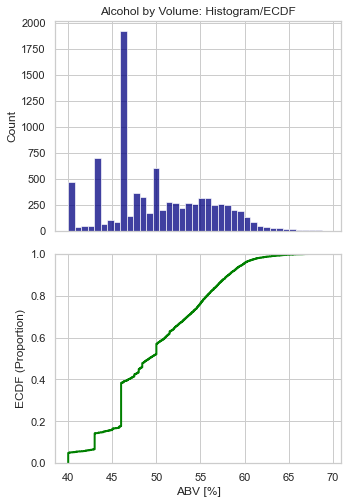

In [6]:
plot_num_attrib(colname = 'ABV', hist_bin_n=40, xlabel='ABV [%]', title="Alcohol by Volume: Histogram/ECDF", data = whisk_data  )

There are some interesting features in the ABV:

1. There are no scotches below 40% ABV. This turns out to be due to a legal requirement in Scotland.
2. At <= 50 % ABV there seems to be a set of discrete steps in the ECDF with a particularly large jump at 46% ABV. This means that a lot of Scotches are bottled by manufacturers at exactly at 46% ABV. 
3. These discrete jumps suggest cutting the ABVs into ranges where ranges are the plateaus.

## Distribution: Whisky Aging Time

The largest number of SCotches are aged to ~ 10-12 years. There is a drop off at ~ 16-18 year age expression range. This drop off is not a bin-bias phenomena as the ECDF shows curvature changes near this point. Then the counts shoots back up at ~ 20 years and goes back down gradually tailing off at aging > 30 years.

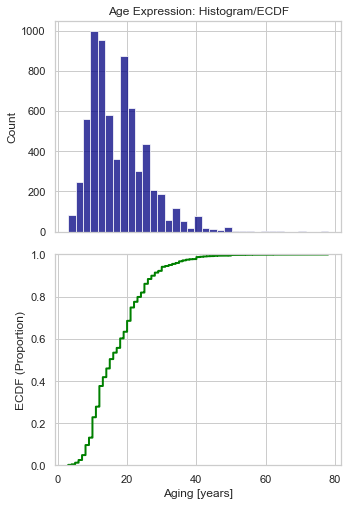

In [7]:
plot_num_attrib(colname = 'age', hist_bin_n=35 ,xlabel='Aging [years]', title="Age Expression: Histogram/ECDF", data = whisk_data  )

## Distribution: Whisky Pricing

There are examples of extremely rare and expensive whiskies. Some rare scotches are at prices of ~ 10K and are collector's items. We're going to clip the plot output to ~ $1,000 do that we can see also visualize the count distribution in the lower price bracket ( < $100). Clearly, most whiskies lie in this reigion and with the distribution peaked at ~$40-90. There are very ffew scotches below $40 and there clearly is a small but nonzero number of whiskies that lie in the high price trail (>$200).

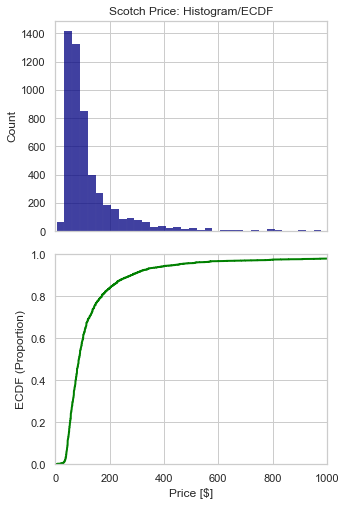

In [8]:
plot_num_attrib(colname = 'price', hist_bin_n=2000, xlabel='Price [$]', title="Scotch Price: Histogram/ECDF", x_extent=(0,1000), data = whisk_data  )


## Maturation Breakdown

In [9]:
whisk_data.columns[whisk_data.columns.str.contains('maturation')]


Index(['maturation_bourbon', 'maturation_brandy', 'maturation_marsala',
       'maturation_oak', 'maturation_port', 'maturation_red wine',
       'maturation_rum', 'maturation_rye', 'maturation_sauternes',
       'maturation_sherry', 'maturation_white wine', 'maturation_wine'],
      dtype='object')

In [10]:
maturation_cols = whisk_data.columns[whisk_data.columns.str.contains('maturation')]
maturation_subset = whisk_data[maturation_cols]
maturation_subset.head(3)

,maturation_bourbon,maturation_brandy,maturation_marsala,maturation_oak,maturation_port,maturation_red wine,maturation_rum,maturation_rye,maturation_sauternes,maturation_sherry,maturation_white wine,maturation_wine
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [11]:
cask_count = maturation_subset.sum(axis=0).sort_values(ascending = False)
print(cask_count)

maturation_sherry        1693.0
maturation_bourbon       1493.0
maturation_oak            564.0
maturation_wine           335.0
maturation_port           141.0
maturation_red wine        66.0
maturation_sauternes       45.0
maturation_rum             41.0
maturation_marsala         30.0
maturation_rye              9.0
maturation_brandy           6.0
maturation_white wine       3.0
dtype: float64


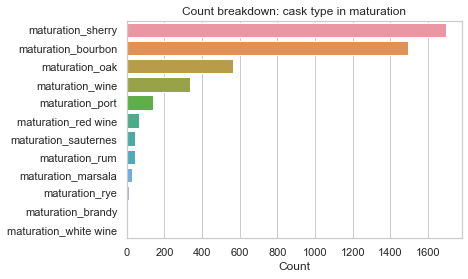

In [12]:
sns.barplot(y = list(cask_count.index), x = cask_count.values)
plt.title('Count breakdown: cask type in maturation')
plt.xlabel('Count')
plt.show()

Sherry and bourbon cask aging seem to be the dominant ones out of the whiskies from which we could extract descriptions (which is probably a representative sample of the population). Wine cask maturation (red wine, sauternes, and marsala are part of this class) and port are the next most frequent cask maturation / finishes. Surprisingly, there are not that many rum finishes present in the counting.

Next, let's check to see if there any correlation between the types of casks used in the aging process.

<AxesSubplot:>

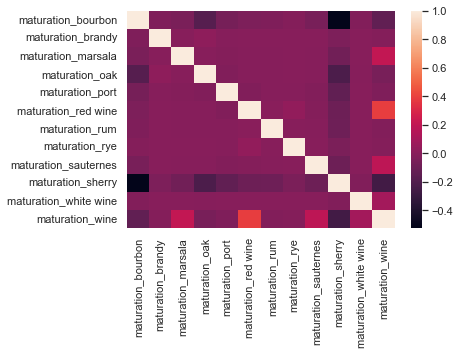

In [13]:
sns.heatmap(maturation_subset.corr())

A few thing pops out: 
1. Sherry and bourbon maturation are highly anticorrelated. This means that the two cask types tend to be mutually exclusive for the maturation of scotches.
2. There is clearly some co-occurence between oak maturation and bourbon maturation. The same goes for sherry and oak maturation.
3. Marsala, red wine, and Sauternes all have positive correlation with the general wine maturation class. This is comforting as they are all wines.


Checking the number of whiskies in the intersection of the sherry AND bourbon maturation reveals that there are whiskies that are matured in both cask types, but that by and large scotches are aged in one or the other.

In [14]:
((maturation_subset.maturation_sherry == 1) & (maturation_subset.maturation_bourbon == 1) ).sum()

190

## Word Cloud Visualization

There is some value in visualizing the count distribution for tokens using wordclouds to get a feel for what descriptors are relevant/prominent. 

In [15]:
def wd_cld_descriptor(data, col_name):

    # we want a flattened list of all the tokens for the wordcloud generator
    attr_listed = [ast.literal_eval(row) for row in data[col_name] ]
    attr_flattened = list(itertools.chain.from_iterable(attr_listed))
    
    attr_string=(" ").join(attr_flattened)
    mask = np.array(Image.open('whiskey_bottle.jfif'))
    wordcloud = WordCloud(background_color = "black", mask=mask, contour_color = 'red', width=mask.shape[1], height=mask.shape[0]).generate(attr_string)
    # wordcloud = WordCloud(background_color = "black").generate(attr_string)
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud)

    
    title_name = "Scotch descriptors" 

    font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }

    plt.title(title_name, fontdict=font)
    plt.axis("off")

    

    plt.savefig(eda_image_path + "wc_"+ col_name + ".jpg", dpi = 300, bbox_inches='tight')
    plt.show()
    plt.close()

In [16]:
whisk_token_path = "data\\interim\\whisk_unified_tokenized.csv"

whisk_tok_df = pd.read_csv(whisk_token_path)

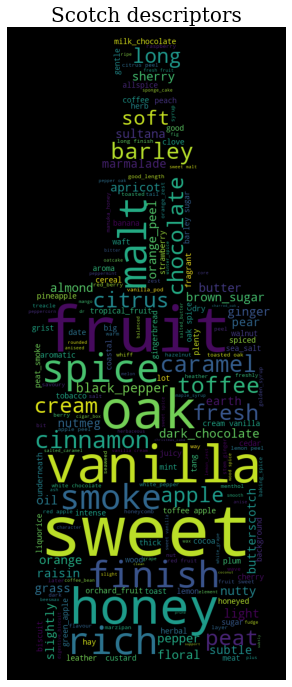

In [17]:
wd_cld_descriptor(whisk_tok_df, "token_unified")

These mostly seem like good descriptors for a scotch.

One thing to note is that sweet descriptors seem to be prevalent at the top of the wordcloud. "Sweet", "vanilla", "honey", "cinnamon", "fruit", "caramel". It could be good to see why this is the case (i.e. are these common descriptors of all scotches in the collection? or are they characteristics of a subgroup that is a very large presence within the entire collection?). 

## Parsing sensory descriptions across Scotch whisky producing regions
Scotches from different regions are known to have different characteristics. Let's see if we can visualize some of these differences.

In [18]:
# we have 477 descriptors in the unified corpus
col_series = list(whisk_data.columns[-481::])
col_series.append('region')
df_subset = whisk_data[col_series]
BoWbyregion = df_subset.groupby('region').sum().reset_index()

BoWbyregion


,region,maturation_sauternes,maturation_sherry,maturation_white wine,maturation_wine,barley,butter,cereal,cut_grass,fruit,...,strong,huge,latte,right,warming,pine_resin,exotic_spice,star_anise,porridge_oats,particularly
0,Campbeltown Whisky,2.0,47.0,0.0,14.0,27.0,18.0,11.0,1.0,108.0,...,0.0,3.0,0.0,2.0,1.0,4.0,1.0,3.0,2.0,2.0
1,Highland Whisky,12.0,441.0,0.0,99.0,531.0,267.0,136.0,14.0,1003.0,...,10.0,18.0,19.0,13.0,16.0,14.0,17.0,21.0,18.0,16.0
2,Island Whisky,5.0,118.0,1.0,23.0,150.0,60.0,47.0,3.0,277.0,...,6.0,7.0,3.0,9.0,10.0,1.0,2.0,1.0,1.0,3.0
3,Islay Whisky,11.0,274.0,0.0,72.0,288.0,151.0,47.0,4.0,706.0,...,22.0,32.0,7.0,16.0,25.0,15.0,12.0,12.0,3.0,7.0
4,Lowland Whisky,1.0,38.0,0.0,17.0,79.0,32.0,28.0,6.0,166.0,...,2.0,3.0,1.0,0.0,4.0,4.0,4.0,3.0,4.0,2.0
5,Other Scotch Whisky,0.0,4.0,0.0,0.0,12.0,4.0,3.0,0.0,15.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Scotch Whisky,0.0,45.0,0.0,16.0,62.0,34.0,17.0,3.0,150.0,...,5.0,2.0,1.0,1.0,4.0,1.0,7.0,0.0,0.0,1.0
7,Speyside Whisky,14.0,726.0,2.0,94.0,985.0,559.0,218.0,38.0,1783.0,...,17.0,13.0,28.0,21.0,63.0,26.0,29.0,27.0,29.0,23.0


We'll loop through and save the top 50 most frequent words in each region:

In [19]:
word_cnt_byregion = pd.melt(BoWbyregion, id_vars =['region']).set_index(['region', 'variable']).sort_index().rename(columns = {'value': 'Frequency'})
word_cnt_byregion.index = word_cnt_byregion.index.set_names(['Region', 'Word'])
region_names = word_cnt_byregion.index.get_level_values(0).unique()
print(region_names)

Index(['Campbeltown Whisky', 'Highland Whisky', 'Island Whisky',
       'Islay Whisky', 'Lowland Whisky', 'Other Scotch Whisky',
       'Scotch Whisky', 'Speyside Whisky'],
      dtype='object', name='Region')


There are 6 actual regions here: Speyside, Lowland, Islay, Island (the other islands besides Islay), Highland, and Campbeltown. Let's select these only.

In [20]:
true_regions = region_names.drop(['Other Scotch Whisky', 'Scotch Whisky'])
print(true_regions)

Index(['Campbeltown Whisky', 'Highland Whisky', 'Island Whisky',
       'Islay Whisky', 'Lowland Whisky', 'Speyside Whisky'],
      dtype='object', name='Region')


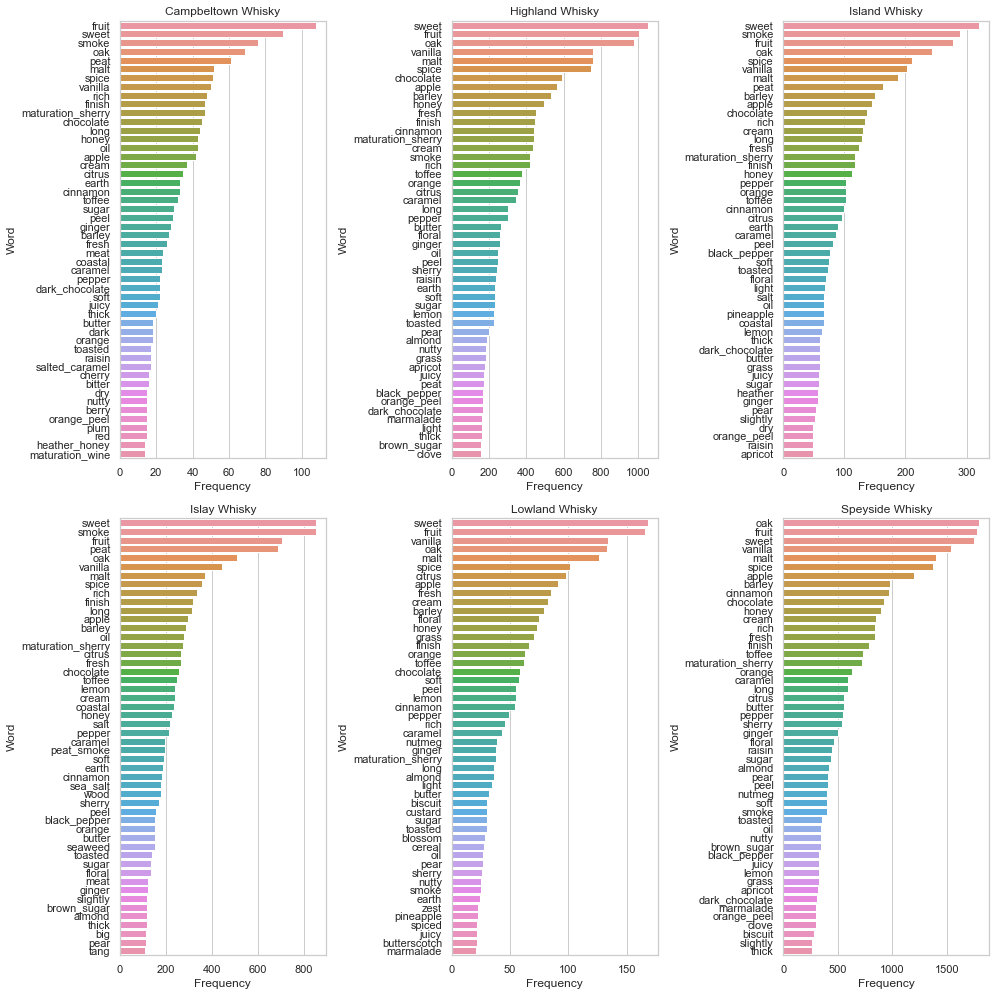

In [21]:
name_shaped = true_regions.to_numpy().reshape(2,3)
nrow, ncol = name_shaped.shape
index_list = list(itertools.product(list(range(nrow)), list(range(ncol)))) # will be used as iterable for subplot
fig, ax = plt.subplots(ncols=3, nrows=2, figsize = (14,14))
for index in index_list:
    name = name_shaped[index]
    topfreqdata = word_cnt_byregion.loc[name].sort_values(by = "Frequency", ascending = False)[0:50]
    sns.barplot(x = 'Frequency', y =topfreqdata.index, data = topfreqdata, ax = ax[index])
    ax[index].set_title(name)
    
plt.tight_layout()
plt.savefig(eda_image_path+'topwordsbyregion.jpg', dpi = 300)



There is a lot of information here. One thing to note is the scale of word frequency for Speyside whiskies. There are a lot more of these than any other region. A little research shows that this is representative of the fact that the Speyside region is the largest Scotch region with the most distilleries in the country. Speyside accounts for over half of the distilleries in Scotland.

The descriptors like 'sweet', 'vanilla', 'malt', 'spice', 'fruit', 'oak', 'apple', 'barley' are in the most frequent descriptors across ALL regions. That means that across the regions, there are many whiskies that contain these characteristics...they're not region specific.

However, there are region specific characteristics. To see this, let's focus on the bottom three regions (Islay, Lowland, and Speyside). Islay whisky has notes that are not prevalent in the other two regions: 'peat', 'smoke'. 'oil' are very high up in the Islay descriptor list whereas they are much less prominent in Speyside and Lowland whiskies. We can also see that Islay has descriptors in the top 50 that are not present in the other two classes for their top 50: 'coastal', 'salt', 'sea_salt', 'seaweed', 'meat'.

Meanwhile Speysides have descriptors like 'cinnamon', 'chocolate', 'toffee', 'honey', 'caramel', 'rich', 'cream', 'sherry'. So we expect sweeter, rich, dessert-like flavors in these sorts of whiskies.

Lowland whisky has a similar profile as Speyside but not 'rich'. Instead we have words like 'light', 'soft', 'subtle'. 'Grass' is also much more prevalent than in Speysides. So we might expect subtle, fresh notes...whiskies that have sweetness and subtle spice but are light and grassier.

So these descriptors and their ranking by region do make some sense and give a feel for regional flavor. But we're not done. There are a LOT of commonalities between the regions. And within regions there are whiskies that have certain groups of notes that are pronounced while other groups that are within common descriptors of that region are not present in the whisky (e.g., one Speyside whisky is rich and creamy with chocolate, toffee, butter and sherry...on the other hand another is rich and creamy but with lots of citrus notes like orange and with apple spiced with ginger and pepper). These are both Speysides and they share certain qualities but not others. 

While regional distinction has value, we want to be able to understand whiskies in terms of descriptor groupings. This will help us get a dimensionally-reduced picture of the descriptor space, a more general picture of the regions, and of each whisky. This is what we want to look at next:


## Correspondence Analysis

In [22]:
from prince import CA

In [29]:
descript_selector = list(whisk_data.columns[-477::])
descript_selector.append('name')
descriptor_subset = whisk_data[descript_selector].set_index('name')
descriptor_subset.head()

,barley,butter,cereal,cut_grass,fruit,good_length,hay,malt,nut,oak,...,strong,huge,latte,right,warming,pine_resin,exotic_spice,star_anise,porridge_oats,particularly
name,,,,,,,,,,,,,,,,,,,,,
Singleton of Dufftown 12 Year Old,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The GlenDronach 18 Year Old Allardice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lagavulin 2005 (bottled 2020) Pedro Ximénez Cask Finish - Distillers Edition,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Glenfarclas 15 Year Old,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Darkness 8 Year Old,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This is clearly in the form of a contingency table. Let's proceed with the Correspondence Analysis.

In [30]:
ca = CA(n_components=2, n_iter=10, random_state=42)
descriptor_subset.columns.rename('Descriptors', inplace = True)
descriptor_subset.index.rename('Whiskies', inplace = True)

In [31]:
ca = ca.fit(descriptor_subset)
ca_2Dword_embed =ca.column_coordinates(descriptor_subset).rename(columns = {0: 'X', 1: 'Y'})
ca_2Dword_embed.head()

,X,Y
barley,-0.195163,0.000652
butter,-0.247171,-0.175695
cereal,0.393087,-0.116000
cut_grass,-0.590207,0.048482
fruit,0.415806,-0.260575


### Descriptor Visualization under Correspondence Analysis

KeyError: 0

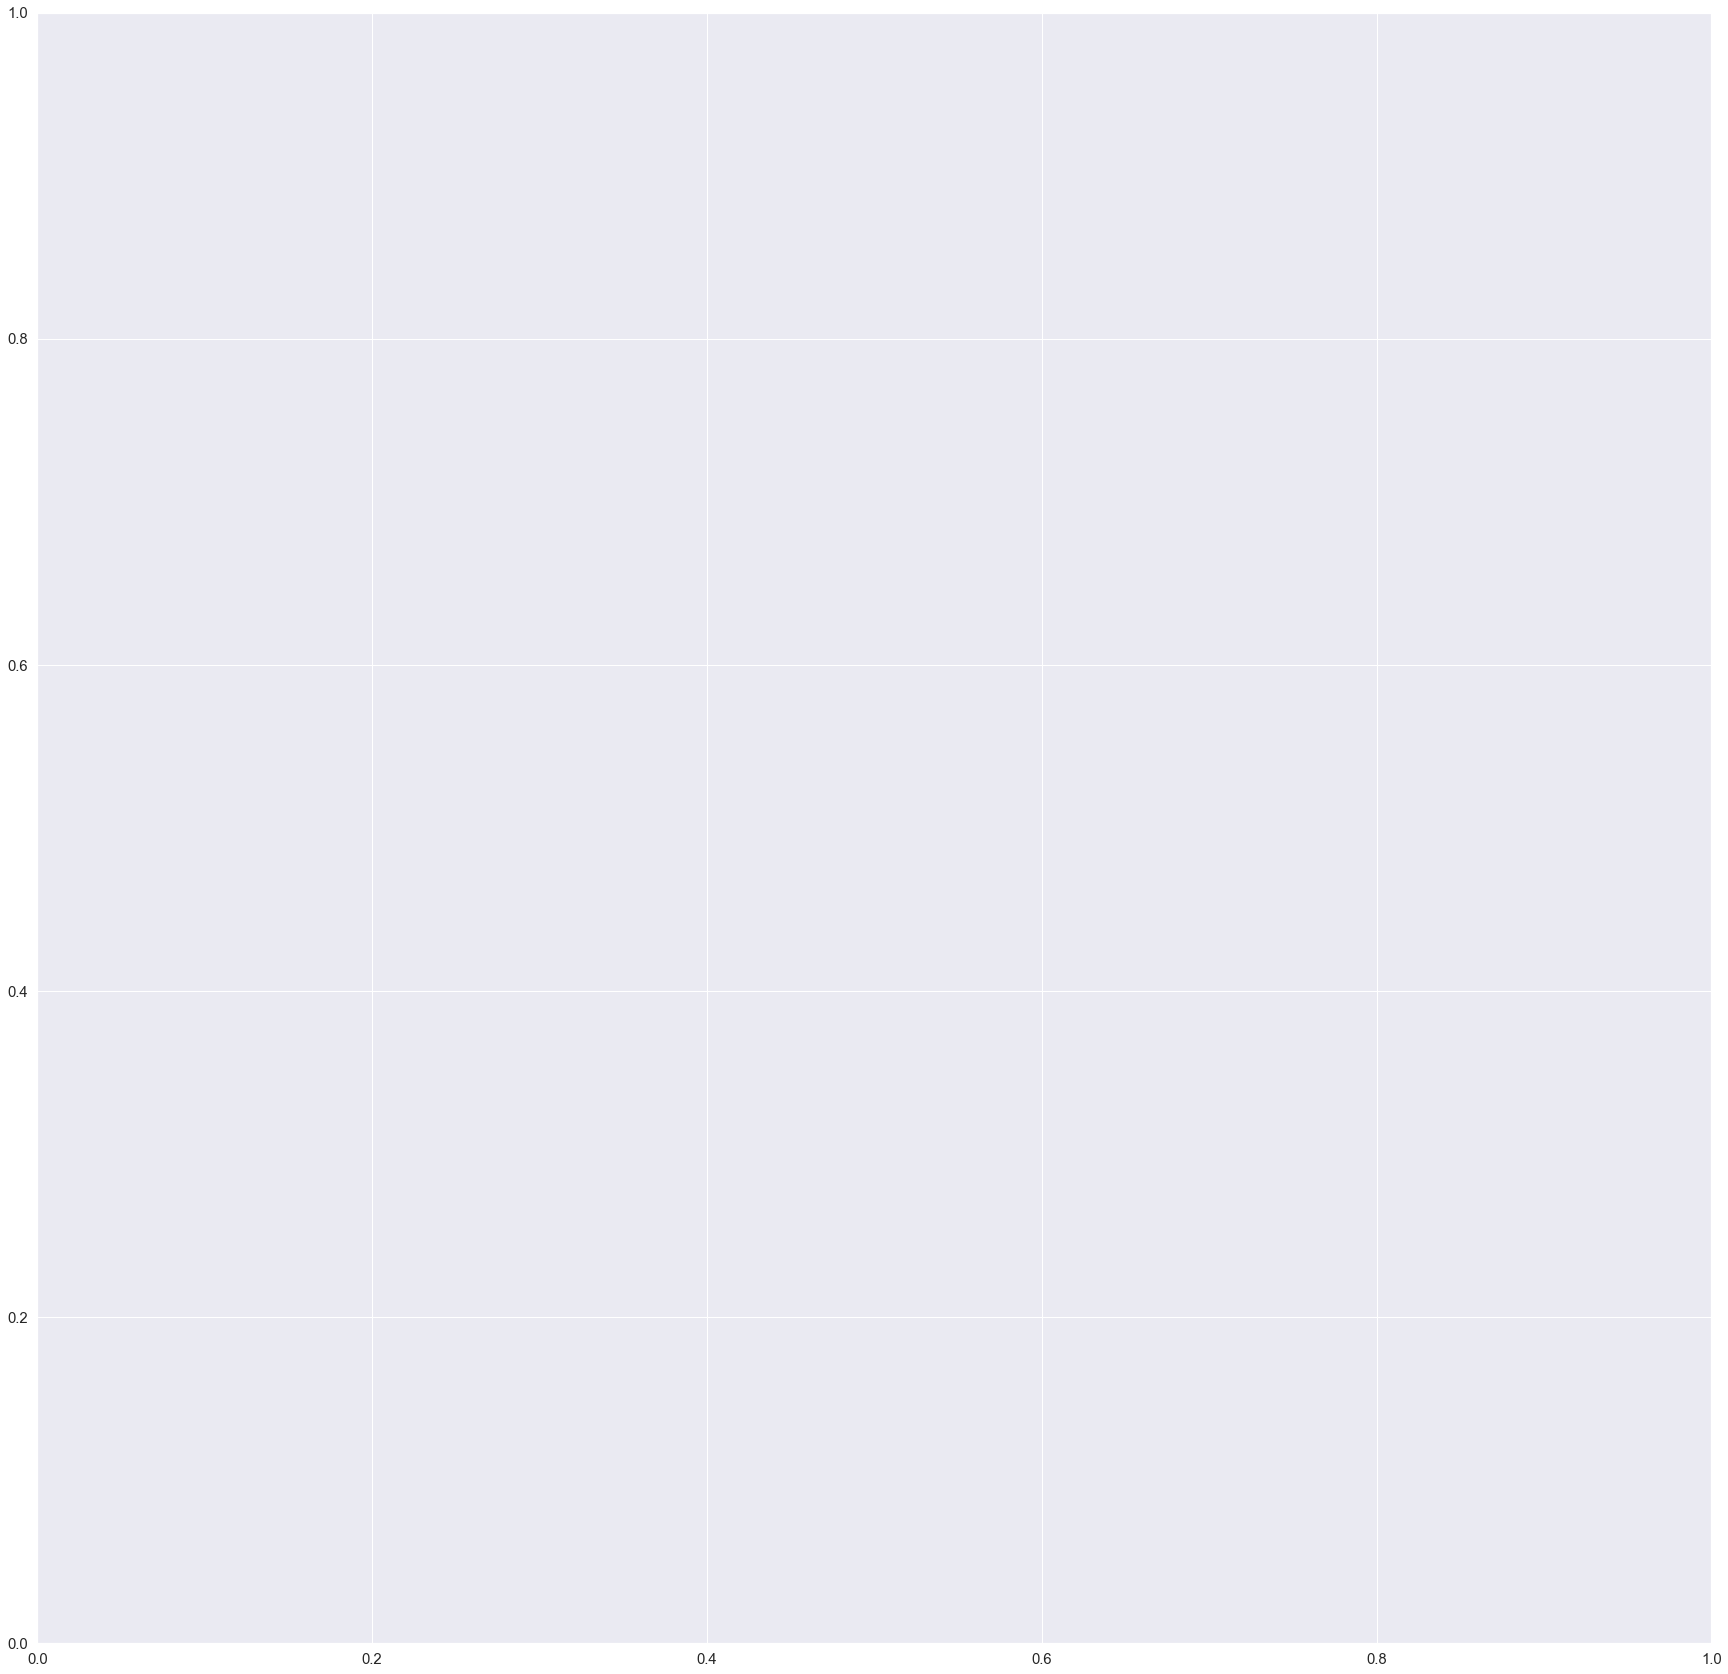

In [32]:
sns.set(font="Arial", font_scale = 1.35)
fig, ax = plt.subplots(figsize = (30,30))
sns.scatterplot(x = ca_2Dword_embed[0], y = ca_2Dword_embed[1])

for word_name in ca_2Dword_embed.index:
    plt.annotate(word_name, (ca_2Dword_embed.loc[word_name, 0], ca_2Dword_embed.loc[word_name, 1]) )

plt.axhline(y=0, c ='r')
plt.axvline(x=0, c = 'r')
plt.title("Scotch Descriptors: Correspondence Analysis Visualization", {'fontname':'Arial', 'fontsize': 25})
plt.xlabel('X', {'fontname':'Arial', 'fontsize': 25})
plt.ylabel('Y', {'fontname':'Arial', 'fontsize': 25})
plt.show()

This representation, which (loosely speaking) keeps word that often co-occur in the corpus closer to each other in a lower dimensional space, is creating regions of descriptors that are recognizably similar/related in terms of sensory information (taste/smell/etc.). 

The region close to X=0 and Y< 0 thats at the bottom of the main cloud and below have pretty similar characteristics: 'christmas', 'raisin', 'christmas_cake', 'fruitcake', 'liqueur', 'pudding', sultanas', 'sticky_toffee', 'stewed', 'fig', 'rum', 'molasses', 'treacle', 'marzipan', 'date', 'nutmeg', 'baking spice', 'strawberry_jam', etc. --> These are all very thick, sweet, deep sugary, sweet-spice and holiday-like flavors.

As we go over larger X > 0 in the bottom right quandrant, the character changes. We have cocoa, mixed peel, aniseed, star anise, manuka honey, pipe tobacco, espresso, bittersweet. These are all tastes balanced between bitter and sweet or having notes of both.

As we go higher in Y, we start to get (roughly speaking) more astringent and sour notes: rhubarb, tannin, acacia, wine,...and going further up in Y and closer to X = 0: 'citrus', grapefruit', 'dry', 'grass', 'crisp', 'lemon_'zest', 'fennel'...etc.

Even higher as Y > 1, we also see a distinct set of flavors that are grouped together. These are salty, smoky, savory notes: "salt", "coastal", "seaweed", "iodine", "peat", "peat_smoke", "meat", "ham", "charred", "bbq", "bonfire", etc. 


In summary, in a rough sort of way we can say that increasing along Y we go from sweet/thick to sour/astringent/floral/aromatic to salty/savoury/smoky descriptors. This is more a continuum than clusters of distinct tastes...which makes sense given the complexity and multifaced nature of Scotches. So while we wont be able to do strict clustering (though visualizing an agglomerative hierarchical model might not be bad), we do have a sense that there are a few groups of descriptors. There is some overlap between the descriptor group regions, some ambiguity in some of the descriptors. This is a good candidate for topic modeling of the whiskey reviews via Latent Dirichlet Allocation (where we can guess topic numbers >= 3 based on our CA visualization).


### Scotch visualization under Correspondence Analysis

Before we go on to topic modeling let's just take a quick look at how the Scotches by region are distributed in this embedding space.

In [33]:
CA_scotch_embed = ca.row_coordinates(descriptor_subset).reset_index().rename(columns = {'index':'name', 0: 'X', 1: 'Y'})
CA_scotch_embed = pd.merge(left = whisk_data, right = CA_scotch_embed, on = 'name').loc[:, ['name', 'region', 'X', 'Y']]
CA_scotch_embed = CA_scotch_embed[(CA_scotch_embed.region != 'Scotch Whisky') & (CA_scotch_embed.region != 'Other Scotch Whisky')]
# CA_scotch_embed = CA_scotch_embed[(CA_scotch_embed.region == 'Campbeltown Whisky') | (CA_scotch_embed.region == 'Speyside Whisky')]
CA_scotch_embed.head()

,name,region,X,Y
0,Singleton of Dufftown 12 Year Old,Speyside Whisky,0.325130,-0.425807
1,The GlenDronach 18 Year Old Allardice,Highland Whisky,-0.584602,-0.544559
2,Lagavulin 2005 (bottled 2020) Pedro Ximénez Ca...,Islay Whisky,0.105046,0.737256
3,Glenfarclas 15 Year Old,Speyside Whisky,0.769898,-0.641313
5,Tobermory 12 Year Old,Island Whisky,-0.343966,-0.249545


<AxesSubplot:xlabel='X', ylabel='Y'>

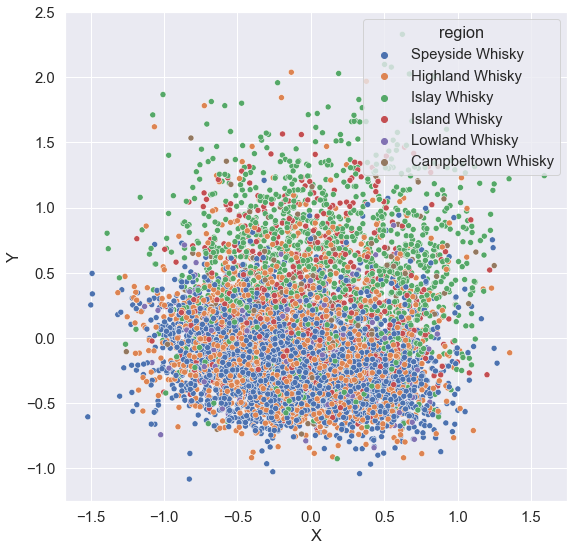

In [34]:
fig, ax = plt.subplots(figsize=(9,9))
sns.scatterplot(x = 'X', y = 'Y', hue = 'region', ax=ax, data = CA_scotch_embed)


We can see that Speysides dominate the sweeter/rich lower Y sector of the embedding space. On the other hand, Islay and Island scotches dominate the higher Y values (smoky, salty, savoury). Highland scotches seem to be equidistributed across all the different descriptor types. It's harder to discern what's going on with the Lowlands and Campeltown's.

Maybe making density plots of the scotches by region might make sense.

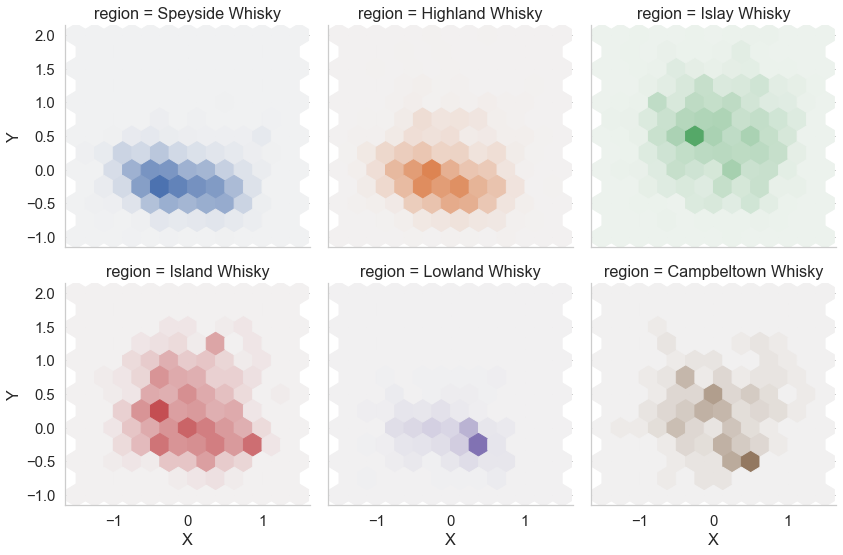

In [35]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=12, cmap=cmap, **kwargs)

with sns.axes_style("whitegrid"):
    g = sns.FacetGrid(CA_scotch_embed, hue="region", col="region", col_wrap = 3, height=4)
g.map(hexbin, "X", "Y", extent = [-1.5, 1.5, -1, 2])

The Speyside whiskies and Islay whiskies clearly have distributions peaked in different locations: the bulk of the Speysides are located at Y < 0 corresponding to sweet descriptors (see descriptor embedding plot for reference). Islay has heavier densities near sharp citrus and dry notes as well as peaty, smoky, salty, meaty descriptors at Y >= 0.5. 

Island whiskies (e.g., Isle of Skye, Jura, Arran, Orkney, etc. ) have those big smoky, salty, peaty flavors but we've also got some dry, astringent, and bittersweet notes. 

Campbelltown has sweetness (low Y values), but also dry/citrusy (X~ -0.5, Y ~ 0.5) notes, a little less than Island/Islay on the smoke and peat (which are the highest Y values) but saltiness (high Y values but a little smaller in Y than the peat notes). 

One observation is that there are, not surprisingly (given the amount of sweet descriptors in the corpus), a non-negligible density of scotches in the sweet sector for all of the regions. This is more to the point that likely many of these scotches are salty, meaty, AND have some sweet notes of toffee, caramel, etc. This implies that while the CA method of embedding is good for visualizing the descriptors, we want a better feature set for describing the whiskies.

We'll finish by saving the CA row and column coordinate embedding . It might be useful later on down the line.

In [36]:
CA_scotch_embed.to_csv('data\\interim\\CA_scotch_embed.csv') # save row embedding
ca_2Dword_embed.to_csv('data\\interim\\CA_descriptor_embed.csv') # save column embedding